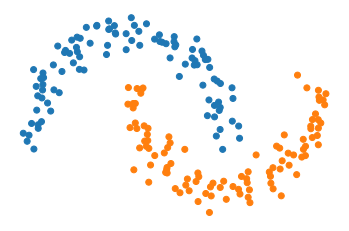

Epoch 1/6
30/30 - 7s - loss: 0.4712 - accuracy: 0.6333 - val_loss: 0.4245 - val_accuracy: 0.7600
Epoch 2/6
30/30 - 7s - loss: 0.3522 - accuracy: 0.7933 - val_loss: 0.2650 - val_accuracy: 0.8400
Epoch 3/6
30/30 - 6s - loss: 0.2348 - accuracy: 0.8467 - val_loss: 0.1924 - val_accuracy: 0.8600
Epoch 4/6
30/30 - 6s - loss: 0.1813 - accuracy: 0.8600 - val_loss: 0.1676 - val_accuracy: 0.8600
Epoch 5/6
30/30 - 6s - loss: 0.1573 - accuracy: 0.8800 - val_loss: 0.1582 - val_accuracy: 0.8600
Epoch 6/6
30/30 - 7s - loss: 0.1438 - accuracy: 0.9000 - val_loss: 0.1569 - val_accuracy: 0.8600
Epoch 1/6
30/30 - 14s - loss: 0.2791 - accuracy: 0.8533 - val_loss: 0.2000 - val_accuracy: 0.8400
Epoch 2/6
30/30 - 14s - loss: 0.1835 - accuracy: 0.8733 - val_loss: 0.1649 - val_accuracy: 0.8600
Epoch 3/6
30/30 - 15s - loss: 0.1550 - accuracy: 0.9000 - val_loss: 0.1548 - val_accuracy: 0.8600
Epoch 4/6
30/30 - 15s - loss: 0.1420 - accuracy: 0.8933 - val_loss: 0.1552 - val_accuracy: 0.8600
Epoch 5/6
30/30 - 16s - lo

In [1]:
r"""
Hybrid quantum-classical ML using Keras and PyTorch
===================================================

.. meta::
    :property="og:description": Learn how to create hybrid ML models in PennyLane using the Keras and PyTorch interfaces
    :property="og:image": https://pennylane.ai/qml/_images/qnn21.png

In PennyLane, variational quantum circuits are treated as :doc:`quantum nodes
<../glossary/hybrid_computation>` (QNodes) that can be thought of simply as functions with a
defined output and gradient for a given input. QNodes can be combined with classical nodes to
form a hybrid model, which can be trained using the TensorFlow, PyTorch or Autograd/NumPy
:doc:`interfaces <introduction/interfaces>`.

Composing computational nodes is a fundamental tool of any machine learning package. However,
it is often useful to have access to additional high-level functionality for model construction
and training. TensorFlow and PyTorch both provide a high-level API for creating neural networks:
TensorFlow integrates with `Keras <https://keras.io/>`__ while PyTorch includes a
`torch.nn <https://pytorch.org/docs/stable/nn.html>`__ module.

This tutorial shows how QNodes in PennyLane can be interfaced with `Keras <https://keras.io/>`__ and
`torch.nn <https://pytorch.org/docs/stable/nn.html>`__ to provide a high-level approach to
creating hybrid quantum-classical models.

Fixing the dataset and problem
------------------------------

Let us begin by choosing a simple dataset and problem to allow us to focus on how the hybrid
model is constructed. Our objective is to classify points generated from scikit-learn's
`make_moons() <https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html>`__ dataset:
"""

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import tensorflow as tf

X, y = make_moons(n_samples=200, noise=0.1)
y_hot = tf.keras.utils.to_categorical(y, num_classes=2)  # one-hot encoded labels

c = ['#1f77b4' if y_ == 0 else '#ff7f0e' for y_ in y]  # colours for each class
plt.axis('off')
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

###############################################################################
# Defining a QNode
# ----------------
#
# Our next step is to define the QNode that we want to interface with `Keras <https://keras.io/>`__
# or `torch.nn <https://pytorch.org/docs/stable/nn.html>`__. Any combination of device, operations
# and measurements that is valid in PennyLane can be used to compose the QNode. However,
# the QNode arguments must satisfy additional
# `conditions <https://pennylane.readthedocs.io/en/stable/code/api/pennylane.qnn.KerasLayer.html#usageDetails>`__
# including having an argument called ``inputs``. All other arguments must be arrays or tensors
# and are treated as trainable weights in the model. We fix a two-qubit QNode using the
# :doc:`default.qubit <code/api/pennylane.plugins.default_qubit.DefaultQubit>` simulator and
# operations from the :doc:`templates <introduction/templates>` module.

import pennylane as qml

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)


@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

###############################################################################
# Note that we do not need to specify the ``interface`` argument in the :func:`~pennylane.qnode`
# decorator.
#
# Interfacing with Keras and Torch
# --------------------------------
#
# With the QNode defined, we are ready to interface with `Keras <https://keras.io/>`__ or
# `torch.nn <https://pytorch.org/docs/stable/nn.html>`__. This is achieved using the
# :class:`~pennylane.qnn.KerasLayer` and :class:`~pennylane.qnn.TorchLayer` classes of the
# :mod:`~pennylane.qnn` module, which convert the QNode to the elementary building block of these
# high-level frameworks: a *layer*. We shall see in the following how the resultant layer can be
# combined with other well-known neural network layers to form a hybrid model.
#
# We must first define the ``weight_shapes`` dictionary. Recall that all of
# the arguments of the QNode except for the ``inputs``-named argument are treated as trainable
# weights. For the QNode to be successfully converted to a layer in `Keras <https://keras.io/>`__ or
# `torch.nn <https://pytorch.org/docs/stable/nn.html>`__, we need to provide the details of the
# shape of each trainable weight for them to be initialized. The ``weight_shapes`` dictionary
# maps from the argument names of the QNode to corresponding shapes:

n_layers = 3
weight_shapes = {"weights": (n_layers, n_qubits, 3)}

###############################################################################
# In our example, the ``weights`` argument of the QNode is trainable and has shape given by
# ``(n_layers, n_qubits, 3)`` which are passed to
# :func:`~pennylane.templates.layers.StronglyEntanglingLayers`.
#
# With ``weight_shapes`` defined, it is easy to then convert the QNode. To convert to
# `Keras <https://keras.io/>`__:

qlayer_tf = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

###############################################################################
# To convert to `torch.nn <https://pytorch.org/docs/stable/nn.html>`__:

qlayer_torch = qml.qnn.TorchLayer(qnode, weight_shapes)

###############################################################################
# With this done, the rest is just working with your favourite classical machine learning library!
#
# Creating a hybrid model
# -----------------------
#
# Let's create a basic three-layered hybrid model consisting of:
#
# 1. A 2-neuron fully connected classical layer
# 2. Our 2-qubit QNode converted into a layer
# 3. Another 2-neuron fully connected classical layer
# 4. A softmax activation to convert to a probability vector
#
# A diagram of the model can be seen in the figure below.
#
# .. figure:: /demonstrations/qnn_module/qnn.png
#    :width: 100%
#    :align: center
#
# We can construct the model using the ``Sequential`` API in both `Keras <https://keras.io/>`__ and
# `torch.nn <https://pytorch.org/docs/stable/nn.html>`__. First, using `Keras
# <https://keras.io/>`__
# `Sequential <https://www.tensorflow.org/api_docs/python/tf/keras/Sequential>`__:

clayer_tf_1 = tf.keras.layers.Dense(2)
clayer_tf_2 = tf.keras.layers.Dense(2, activation="softmax")
model_tf = tf.keras.models.Sequential([clayer_tf_1, qlayer_tf, clayer_tf_2])

###############################################################################
# Similarly, using `torch.nn <https://pytorch.org/docs/stable/nn.html>`__
# `Sequential <https://pytorch.org/docs/stable/nn.html#sequential>`__:

import torch

clayer_torch_1 = torch.nn.Linear(2, 2)
clayer_torch_2 = torch.nn.Linear(2, 2)
softmax_torch = torch.nn.Softmax(dim=1)
layers_torch = [clayer_torch_1, qlayer_torch, clayer_torch_2, softmax_torch]
model_torch = torch.nn.Sequential(*layers_torch)

###############################################################################
# Constructing hybrid models is easy!
#
# Training the model
# ------------------
#
# We can now train our hybrid model on the the classification dataset using the usual
# approaches in `Keras <https://keras.io/>`__ and
# `torch.nn <https://pytorch.org/docs/stable/nn.html>`__. Let's focus on Keras. We'll use the
# standard `SGD <https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD>`__ optimizer
# and the mean absolute error loss function:

opt = tf.keras.optimizers.SGD(learning_rate=0.2)
model_tf.compile(opt, loss='mae', metrics=['accuracy'])

###############################################################################
# Note that there are more advanced combinations of optimizer and loss function, but here we are
# focusing on the basics.
#
# The model is now ready to be trained!

X = X.astype("float32")
y_hot = y_hot.astype("float32")
model_tf.fit(X, y_hot, epochs=6, batch_size=5, validation_split=0.25, verbose=2)

###############################################################################
# Creating non-sequential models
# ------------------------------
#
# The models we created above were composed of a sequence of classical and quantum layers. This
# type of model is very common and is suitable in a lot of situations. However, in some cases we
# may want a greater degree of control over how the model is constructed, for example when we
# have multiple inputs and outputs or when we want to distribute the output of one layer into
# multiple subsequent layers.
#
# Suppose we want to make a hybrid model consisting of:
#
# 1. A 4-neuron fully connected classical layer
# 2. A 2-qubit quantum layer connected to the first two neurons of the previous classical layer
# 3. A 2-qubit quantum layer connected to the second two neurons of the previous classical layer
# 4. A 2-neuron fully connected classical layer which takes a 4-dimensional input from the
#    combination of the previous quantum layers
# 5. A softmax activation to convert to a probability vector
#
# A diagram of the model can be seen in the figure below.
#
# .. figure:: /demonstrations/qnn_module/qnn2.png
#    :width: 100%
#    :align: center
#
# This model can also be constructed in the `Keras <https://keras.io/>`__ and
# `torch.nn <https://pytorch.org/docs/stable/nn.html>`__ interfaces. For
# `Keras <https://keras.io/>`__, we can use the
# `Functional API <https://keras.io/guides/functional_api/>`__:

# re-define the layers
clayer_tf_1 = tf.keras.layers.Dense(4)
qlayer_tf = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
qlayer_tf_2 = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
clayer_tf_2 = tf.keras.layers.Dense(2, activation="softmax")

# construct the model
inputs = tf.keras.Input(shape=(2,))
x = clayer_tf_1(inputs)
x_1, x_2 = tf.split(x, 2, axis=1)
x_1 = qlayer_tf(x_1)
x_2 = qlayer_tf_2(x_2)
x = tf.concat([x_1, x_2], axis=1)
outputs = clayer_tf_2(x)

model_tf = tf.keras.Model(inputs=inputs, outputs=outputs)

###############################################################################
# In `torch.nn <https://pytorch.org/docs/stable/nn.html>`__, we can create a new class that
# inherits from `Module <https://pytorch.org/docs/stable/nn.html#torch.nn.Module>`__:

# re-define the layers
clayer_torch_1 = torch.nn.Linear(2, 4)
qlayer_torch = qml.qnn.TorchLayer(qnode, weight_shapes)
qlayer_torch_2 = qml.qnn.TorchLayer(qnode, weight_shapes)
clayer_torch_2 = torch.nn.Linear(4, 2)
softmax_torch = torch.nn.Softmax(dim=1)


# construct the model
class HybridModel(torch.nn.Module):
    def forward(self, x):
        x = clayer_torch_1(x)
        x_1, x_2 = torch.split(x, 2, dim=1)
        x_1 = qlayer_torch(x_1)
        x_2 = qlayer_torch_2(x_2)
        x = torch.cat([x_1, x_2], axis=1)
        x = clayer_torch_2(x)
        return softmax_torch(x)


model_torch = HybridModel()

###############################################################################
# As a final step, let's train the `Keras <https://keras.io/>`__-based model to check if it's
# working:

opt = tf.keras.optimizers.SGD(learning_rate=0.2)
model_tf.compile(opt, loss='mae', metrics=['accuracy'])

model_tf.fit(X, y_hot, epochs=6, batch_size=5, validation_split=0.25, verbose=2)


In [4]:
model_tf.trainable_weights

[<tf.Variable 'dense_2/kernel:0' shape=(2, 4) dtype=float32, numpy=
 array([[-0.2509018 , -0.42321056,  0.7247603 ,  0.01586316],
        [ 0.8116629 ,  1.0291947 , -1.3607694 ,  1.5181118 ]],
       dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(4,) dtype=float32, numpy=array([-0.45204154,  0.5109252 ,  0.61852527,  0.5234735 ], dtype=float32)>,
 <tf.Variable 'keras_layer_1/weights:0' shape=(3, 2, 3) dtype=float32, numpy=
 array([[[-0.5231164 ,  0.6404351 , -0.24841742],
         [ 0.2344842 ,  0.39584428, -0.75858366]],
 
        [[ 0.15996625, -0.4378964 , -0.25298437],
         [-0.41178626,  0.5565778 ,  0.26855603]],
 
        [[-0.03270602, -0.29790556,  0.01847935],
         [-0.46062246, -0.17656913, -0.07318568]]], dtype=float32)>,
 <tf.Variable 'keras_layer_2/weights:0' shape=(3, 2, 3) dtype=float32, numpy=
 array([[[ 0.17666762,  0.11124631,  0.5485954 ],
         [ 0.41560924,  0.6393192 , -0.47849524]],
 
        [[-0.5295138 , -0.6913386 , -0.7958267 ],
         